In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Bidirectional, LSTM, Reshape, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import os

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    physical_devices[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]
)

In [4]:
train_dataset = image_dataset_from_directory(
    directory='../asl_dataset/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

Found 2515 files belonging to 36 classes.


In [5]:
import cv2
import mediapipe as mp
import numpy as np
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1)

def get_hand_landmarks(image):
    results = hands.process(image)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]

        coordinates_3d = np.zeros((21, 3))

        for i, landmark in enumerate(hand_landmarks.landmark):
            coordinates_3d[i] = [landmark.x, landmark.y, landmark.z]

        return np.reshape(coordinates_3d, (63,))
    else:
        return None


(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)


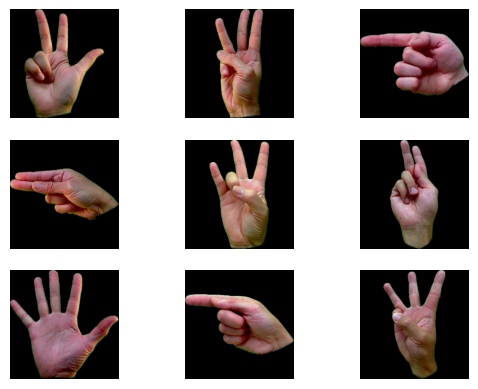

In [6]:
import matplotlib.pyplot as plt
for image_batch, labels_batch in train_dataset:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        landmark = get_hand_landmarks(image_batch[i].numpy().astype("uint8"))
        if not landmark is None:
            print(landmark.shape)
        # print(type(get_hand_landmarks(image_batch[i].numpy().astype("uint8"))))
        plt.axis("off")
    break

In [14]:
def landmarks_for_batch(image_batch, labels_batch):
    landmarks = []
    labels = []
    for image,label in zip(image_batch, labels_batch):
        landmark = get_hand_landmarks(image.numpy().astype("uint8"))
        if not landmark is None:
            landmarks.append(landmark)
            labels.append(label)
    landmarks = np.array(landmarks)
    # print(landmarks.shape)
    return landmarks, labels

In [8]:
for image_batch, labels_batch in train_dataset:
    landmarks = landmarks_for_batch(image_batch)
    print(landmarks.shape)
    break

(32, 63)


In [9]:
class_labels = train_dataset.class_names
len(class_labels)

36

In [10]:
model_inputs = Input(shape=(63,))
x = Dense(128, activation='relu')(model_inputs)
x = Dense(128, activation='relu')(x)

model_outputs = Dense(len(class_labels), activation='softmax')(x)

model = Model(model_inputs, model_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 63)]              0         
                                                                 
 dense (Dense)               (None, 128)               8192      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 36)                4644      
                                                                 
Total params: 29,348
Trainable params: 29,348
Non-trainable params: 0
_________________________________________________________________


In [11]:
OPTIMIZER = Adam(learning_rate=0.001)
LOSS = CategoricalCrossentropy()
EPOCHS = 5

In [17]:
def train_block(model, train_dataset, epochs):
    for i in range(1, epochs + 1):

        for image_batch, labels_batch in train_dataset:
            with tf.GradientTape() as tape:
                landmarks, labels = landmarks_for_batch(image_batch, labels_batch)
                # print(landmarks.shape)
                preds = model(landmarks)
                # print(preds.shape)
                loss = LOSS(labels, preds)
            gradients = tape.gradient(loss, model.trainable_variables)
            OPTIMIZER.apply_gradients(zip(gradients, model.trainable_variables))
        print(f'Epoch {i} Loss: {loss.numpy()}')
train_block(model, train_dataset, EPOCHS)

Epoch 1 Loss: 1.598523736000061
Epoch 2 Loss: 1.2799630165100098
Epoch 3 Loss: 1.1379497051239014
Epoch 4 Loss: 0.812238872051239
Epoch 5 Loss: 0.712739884853363


In [18]:
model.save('model.h5')

In [20]:
import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
cap = cv2.VideoCapture(0)
mp_drawing = mp.solutions.drawing_utils
while True:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame)
    landmarks = get_hand_landmarks(frame)
    if not landmarks is None:
        preds = model.predict(np.expand_dims(landmarks, axis=0))
        class_label = class_labels[np.argmax(preds)]
        print(class_label)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.imshow('Hand Tracking', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
l
1/1 [==============================] - 0s 37ms/step
l
1/1 [==============================] - 0s 32ms/step
l
1/1 [==============================] - 0s 21ms/step
l
1/1 [==============================] - 0s 20ms/step
l
1/1 [==============================] - 0s 22ms/step
l
1/1 [==============================] - 0s 23ms/step
l
1/1 [==============================] - 0s 22ms/step
l
1/1 [==============================] - 0s 20ms/step
l
1/1 [==============================] - 0s 21ms/step
l
1/1 [==============================] - 0s 23ms/step
l
1/1 [==============================] - 0s 26ms/step
l
1/1 [==============================] - 0s 22ms/step
l
1/1 [==============================] - 0s 27ms/step
l
1/1 [==============================] - 0s 24ms/step
l
1/1 [==============================] - 0s 32ms/step
l
1/1 [==============================] - 0s 20ms/step
l
1/1 [==============================] - 0s 20ms/step
l
1/1 [=======================